<a href="https://colab.research.google.com/github/AbhiramGude/Blog/blob/main/Sentimental%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentimental Analysis of Rabindra Sadan Complex

For a proposal for the redevelopment of the Rabindra Sadan Complex, we have gathered people's perceptions using available Google Maps reviews and studied how people have experienced the space from an architectural perspective.

## Data Collection

In [5]:
import pandas as pd
import glob
import os

path = r"/content/"
files = glob.glob(os.path.join(path, "*.xlsx"))

print("Files found:", files)
dfs = [pd.read_excel(f) for f in files]
reviews_df = pd.concat(dfs, ignore_index=True)
print("Data Info")
print(reviews_df.info())

print("\n Missing Values")
print(reviews_df.isnull().sum())

Files found: ['/content/Nandan Area.xlsx', '/content/Paschim Banga Natya Akademi.xlsx', '/content/Sainik Bhawan.xlsx', '/content/Gaganendra Shilpa.xlsx', '/content/Nandan.xlsx', "/content/Raju's Kitchen.xlsx", '/content/Kolkata Information Centre.xlsx', '/content/Charukala Bhavan.xlsx', '/content/Sisir Mancha.xlsx', '/content/Academy of Fine Arts.xlsx', '/content/Rabindra Sadan.xlsx']
Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9464 entries, 0 to 9463
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      9464 non-null   object
 1   url        9464 non-null   object
 2   stars      9464 non-null   int64 
 3   name       9464 non-null   object
 4   reviewUrl  9464 non-null   object
 5   text       7606 non-null   object
dtypes: int64(1), object(5)
memory usage: 443.8+ KB
None

 Missing Values
title           0
url             0
stars           0
name            0
reviewUrl       0
text         1858
dt

## Data Preprocessing

In [6]:
reviews_df = reviews_df.dropna(subset=["text"])
reviews_df = reviews_df.drop(columns=["url","reviewUrl","name"])
unique_titles = reviews_df["title"].unique()
print("Number of Unique Titles:", len(unique_titles))

print("\nNumber of Reviews per Space : ")
for t in unique_titles:
    reviews_count = reviews_df[reviews_df["title"] == t].shape[0]
    print(f"{t}: {reviews_count}")

Number of Unique Titles: 11

Number of Reviews per Space : 
Nandan Area: 34
Paschim Banga Natya Akademi: 17
Sainik Bhawan ZILA SAINIK BOARD KOLKATA: 14
Gaganendra Shilpa Pradarshashala: 175
Nandan: 2998
Raju's Kitchen: 155
Kolkata Information Centre: 25
Rajya Charukala Parshad - Charukala Bhavan: 25
Sisir Mancha: 388
Academy of Fine Arts: 788
Rabindra Sadan: 2987


In [7]:
!pip install translate

In [8]:
## Translation from Bengali Text to English

from translate import Translator

translator = Translator(to_lang="en")

def translate_text(text):
    try:
        # Check if the text is likely Bengali (this is a simple check and might not be perfect)
        # A more robust approach might involve language detection
        if isinstance(text, str) and any('\u0980' <= char <= '\u09FF' for char in text): # Check for Bengali Unicode range and if it's a string
            return translator.translate(text)
        else:
            return text # Return original text if not likely Bengali
    except Exception as e:
        print(f"Translation error: {e}")
        return text # Return original text in case of error


# Apply translation to the 'text' column
# This might take some time depending on the number of reviews
reviews_df['translated_text'] = reviews_df['text'].apply(translate_text)

# Display rows where translation occurred
translated_rows = reviews_df[reviews_df['text'] != reviews_df['translated_text']]
display(translated_rows[['text', 'translated_text']].head())

,text,translated_text


In [9]:
# Select and rename relevant columns
# We are selecting 'title', 'stars', and the 'translated_text' column
sentiment_df = reviews_df[['title', 'stars', 'translated_text']].copy()

# Rename the columns as requested
sentiment_df.rename(columns={
    'title': 'space',
    'stars': 'stars',
    'translated_text': 'review' # Renaming the translated text column to 'review'
}, inplace=True)

# Drop rows where the 'review' column (translated text) is empty
sentiment_df.dropna(subset=['review'], inplace=True)
sentiment_df = sentiment_df[sentiment_df['review'].str.strip() != '']


# Display the new DataFrame
display(sentiment_df.head())

,space,stars,review
0,Nandan Area,5,Lovely place to get rid of all your overthinki...
1,Nandan Area,5,Nandan is a government-sponsored film and cult...
2,Nandan Area,5,Indeed West Bengals heart . The most popular a...
3,Nandan Area,5,"The cultural hub of Bengal, almost all kinds o..."
4,Nandan Area,5,Very nice.... Calming and peaceful place...


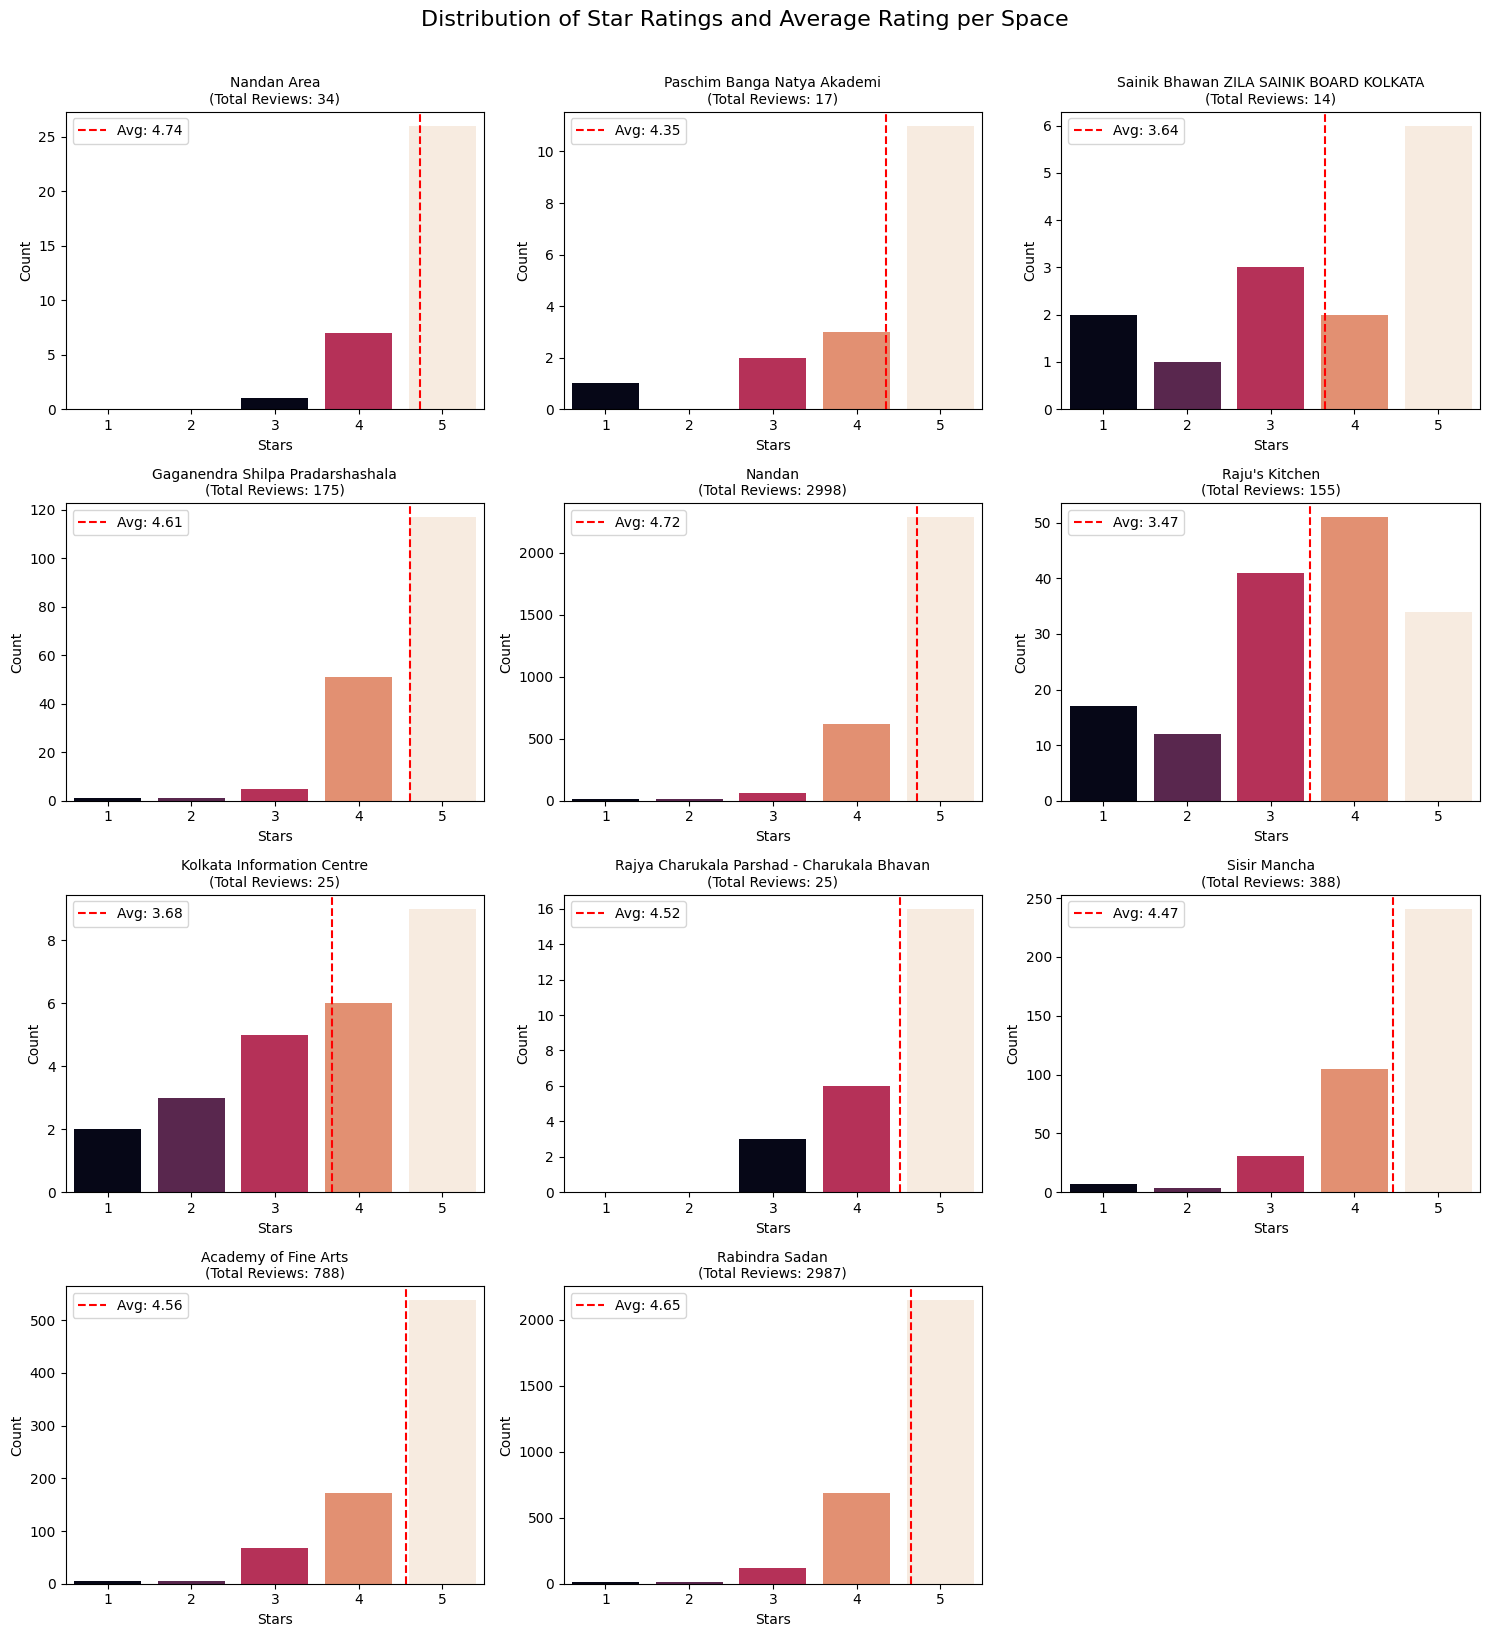

In [10]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Use the new sentiment_df
titles = sentiment_df["space"].unique() # Use 'space' column
n_titles = len(titles)
n_cols = 3
n_rows = math.ceil(n_titles / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

review_counts = {}  # to store review counts per title

for i, t in enumerate(titles):
    # Use the new sentiment_df and 'space' column
    subset = sentiment_df[sentiment_df["space"] == t] # Use 'space' column
    review_count = subset.shape[0]
    # Use the new 'stars' column
    avg_rating = subset["stars"].mean() # Use 'stars' column

    review_counts[t] = review_count  # save review count

    # Countplot of ratings using the new 'stars' column
    sns.countplot(
    data=subset,
    x="stars", # Use the new column name
    hue="stars",
    ax=axes[i],
    palette="rocket",
    order=[1, 2, 3, 4, 5],
    legend=False
     )
# Rating Line
    axes[i].axvline(avg_rating-1, color="red", linestyle="--", label=f"Avg: {avg_rating:.2f}")

    axes[i].set_title(f"{t}\n(Total Reviews: {review_count})", fontsize=10)
    axes[i].set_xlabel("Stars") # Keep label as Stars for clarity
    axes[i].set_ylabel("Count")
    axes[i].legend()

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Star Ratings and Average Rating per Space", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

## Sentimental Analysis

In [11]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.4 MB/s eta 0:00:00


In [12]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download VADER lexicon (if you haven't already)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment scores
def get_vader_sentiment_scores(text):
    if not isinstance(text, str):
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0} # Return neutral scores for non-string inputs
    # Apply VADER to the translated_text column (which retains punctuation)
    return analyzer.polarity_scores(text)

# Apply VADER to the 'review' column and create new columns for scores
sentiment_df['vader_scores'] = sentiment_df['review'].apply(get_vader_sentiment_scores)

# Extract compound score into a separate column
sentiment_df['vader_compound'] = sentiment_df['vader_scores'].apply(lambda x: x['compound'])

# Classify sentiment based on compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sentiment_df['vader_sentiment'] = sentiment_df['vader_compound'].apply(classify_sentiment)


# Display the first few rows with sentiment scores
display(sentiment_df[['review', 'vader_scores', 'vader_compound', 'vader_sentiment']])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,review,vader_scores,vader_compound,vader_sentiment
0,Lovely place to get rid of all your overthinki...,"{'neg': 0.067, 'neu': 0.764, 'pos': 0.168, 'co...",0.6761,Positive
1,Nandan is a government-sponsored film and cult...,"{'neg': 0.0, 'neu': 0.944, 'pos': 0.056, 'comp...",0.3818,Positive
2,Indeed West Bengals heart . The most popular a...,"{'neg': 0.0, 'neu': 0.601, 'pos': 0.399, 'comp...",0.8070,Positive
3,"The cultural hub of Bengal, almost all kinds o...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.8689,Positive
4,Very nice.... Calming and peaceful place...,"{'neg': 0.0, 'neu': 0.244, 'pos': 0.756, 'comp...",0.8508,Positive
...,...,...,...,...
9458,Heart of Kolkata! I must say,"{'neg': 0.0, 'neu': 0.527, 'pos': 0.473, 'comp...",0.6696,Positive
9459,Lovely sound and theatre,"{'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'comp...",0.5859,Positive
9460,Conjested but Good for being with friends..,"{'neg': 0.0, 'neu': 0.385, 'pos': 0.615, 'comp...",0.8402,Positive
9461,After office it's awesome,"{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...",0.6249,Positive


In [13]:
!pip install transformers torch

In [14]:
import torch
from transformers import pipeline
import pandas as pd

# Check if a GPU is available and use it
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

# Load a pre-trained sentiment analysis pipeline
# 'sentiment-analysis' uses a fine-tuned model like 'distilbert-base-uncased-finetuned-sst-2-english' by default
# Specify truncation=True in the pipeline call to handle long sequences
sentiment_pipeline = pipeline("sentiment-analysis", device=device, truncation=True)


# Function to get BERT sentiment prediction
def get_bert_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return {'label': 'Neutral', 'score': 0.0} # Handle non-string or empty input

    # The pipeline returns a list of dicts, e.g., [{'label': 'POSITIVE', 'score': 0.9998}]
    # The pipeline is now initialized with truncation=True, so it handles long texts internally
    result = sentiment_pipeline(text)[0]
    return result

# Apply BERT sentiment analysis to the 'review' column
# This might take a significant amount of time depending on the number of reviews and hardware
print("Performing BERT sentiment analysis... This might take a while.")
sentiment_df['bert_sentiment_raw'] = sentiment_df['review'].apply(get_bert_sentiment)

# Extract label and score into separate columns for easier use
sentiment_df['bert_sentiment_label'] = sentiment_df['bert_sentiment_raw'].apply(lambda x: x['label'])
sentiment_df['bert_sentiment_score'] = sentiment_df['bert_sentiment_raw'].apply(lambda x: x['score'])


# Display the first few rows with BERT sentiment results
display(sentiment_df[['review', 'bert_sentiment_label', 'bert_sentiment_score']].head())

# Display counts per sentiment label
print("\nBERT Sentiment Distribution:")
print(sentiment_df['bert_sentiment_label'].value_counts())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Using device: GPU


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Performing BERT sentiment analysis... This might take a while.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,review,bert_sentiment_label,bert_sentiment_score
0,Lovely place to get rid of all your overthinki...,POSITIVE,0.984590
1,Nandan is a government-sponsored film and cult...,POSITIVE,0.999591
2,Indeed West Bengals heart . The most popular a...,POSITIVE,0.999553
3,"The cultural hub of Bengal, almost all kinds o...",POSITIVE,0.999807
4,Very nice.... Calming and peaceful place...,POSITIVE,0.999873



BERT Sentiment Distribution:
bert_sentiment_label
POSITIVE    6902
NEGATIVE     704
Name: count, dtype: int64


In [15]:
# Display counts per sentiment label for VADER
print("VADER Sentiment Distribution:")
display(sentiment_df['vader_sentiment'].value_counts())

print("\n") # Add a newline for better separation

# Display counts per sentiment label for BERT
print("BERT Sentiment Distribution:")
display(sentiment_df['bert_sentiment_label'].value_counts())

VADER Sentiment Distribution:


,count
vader_sentiment,
Positive,6400
Neutral,980
Negative,226




BERT Sentiment Distribution:


,count
bert_sentiment_label,
POSITIVE,6902
NEGATIVE,704


In [16]:
# Create the final DataFrame with selected and renamed columns
final_sentiment_df = sentiment_df[['space', 'stars', 'review', 'bert_sentiment_score', 'bert_sentiment_label']].copy()

# Rename the columns as requested
final_sentiment_df.rename(columns={
    'space': 'location',
    'stars': 'stars',
    'review': 'review',
    'bert_sentiment_score': 'sentiment score',
    'bert_sentiment_label': 'sentiment (bert)'
}, inplace=True)

# Display the final DataFrame
print("Final DataFrame for Sentiment Analysis Results:")
display(final_sentiment_df)

# Display the total number of rows in the final DataFrame
print(f"\nTotal number of reviews in the final DataFrame: {final_sentiment_df.shape[0]}")

Final DataFrame for Sentiment Analysis Results:


,location,stars,review,sentiment score,sentiment (bert)
0,Nandan Area,5,Lovely place to get rid of all your overthinki...,0.984590,POSITIVE
1,Nandan Area,5,Nandan is a government-sponsored film and cult...,0.999591,POSITIVE
2,Nandan Area,5,Indeed West Bengals heart . The most popular a...,0.999553,POSITIVE
3,Nandan Area,5,"The cultural hub of Bengal, almost all kinds o...",0.999807,POSITIVE
4,Nandan Area,5,Very nice.... Calming and peaceful place...,0.999873,POSITIVE
...,...,...,...,...,...
9458,Rabindra Sadan,5,Heart of Kolkata! I must say,0.999729,POSITIVE
9459,Rabindra Sadan,5,Lovely sound and theatre,0.999876,POSITIVE
9460,Rabindra Sadan,4,Conjested but Good for being with friends..,0.999022,POSITIVE
9461,Rabindra Sadan,5,After office it's awesome,0.999879,POSITIVE



Total number of reviews in the final DataFrame: 7606


In [17]:
from google.colab import auth
auth.authenticate_user()

In [18]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=final_sentiment_df)

https://docs.google.com/spreadsheets/d/1VpxxziP_gVXR55ZA-MEPMAcEcE5LHmLd1mv99pUWNkw/edit#gid=0


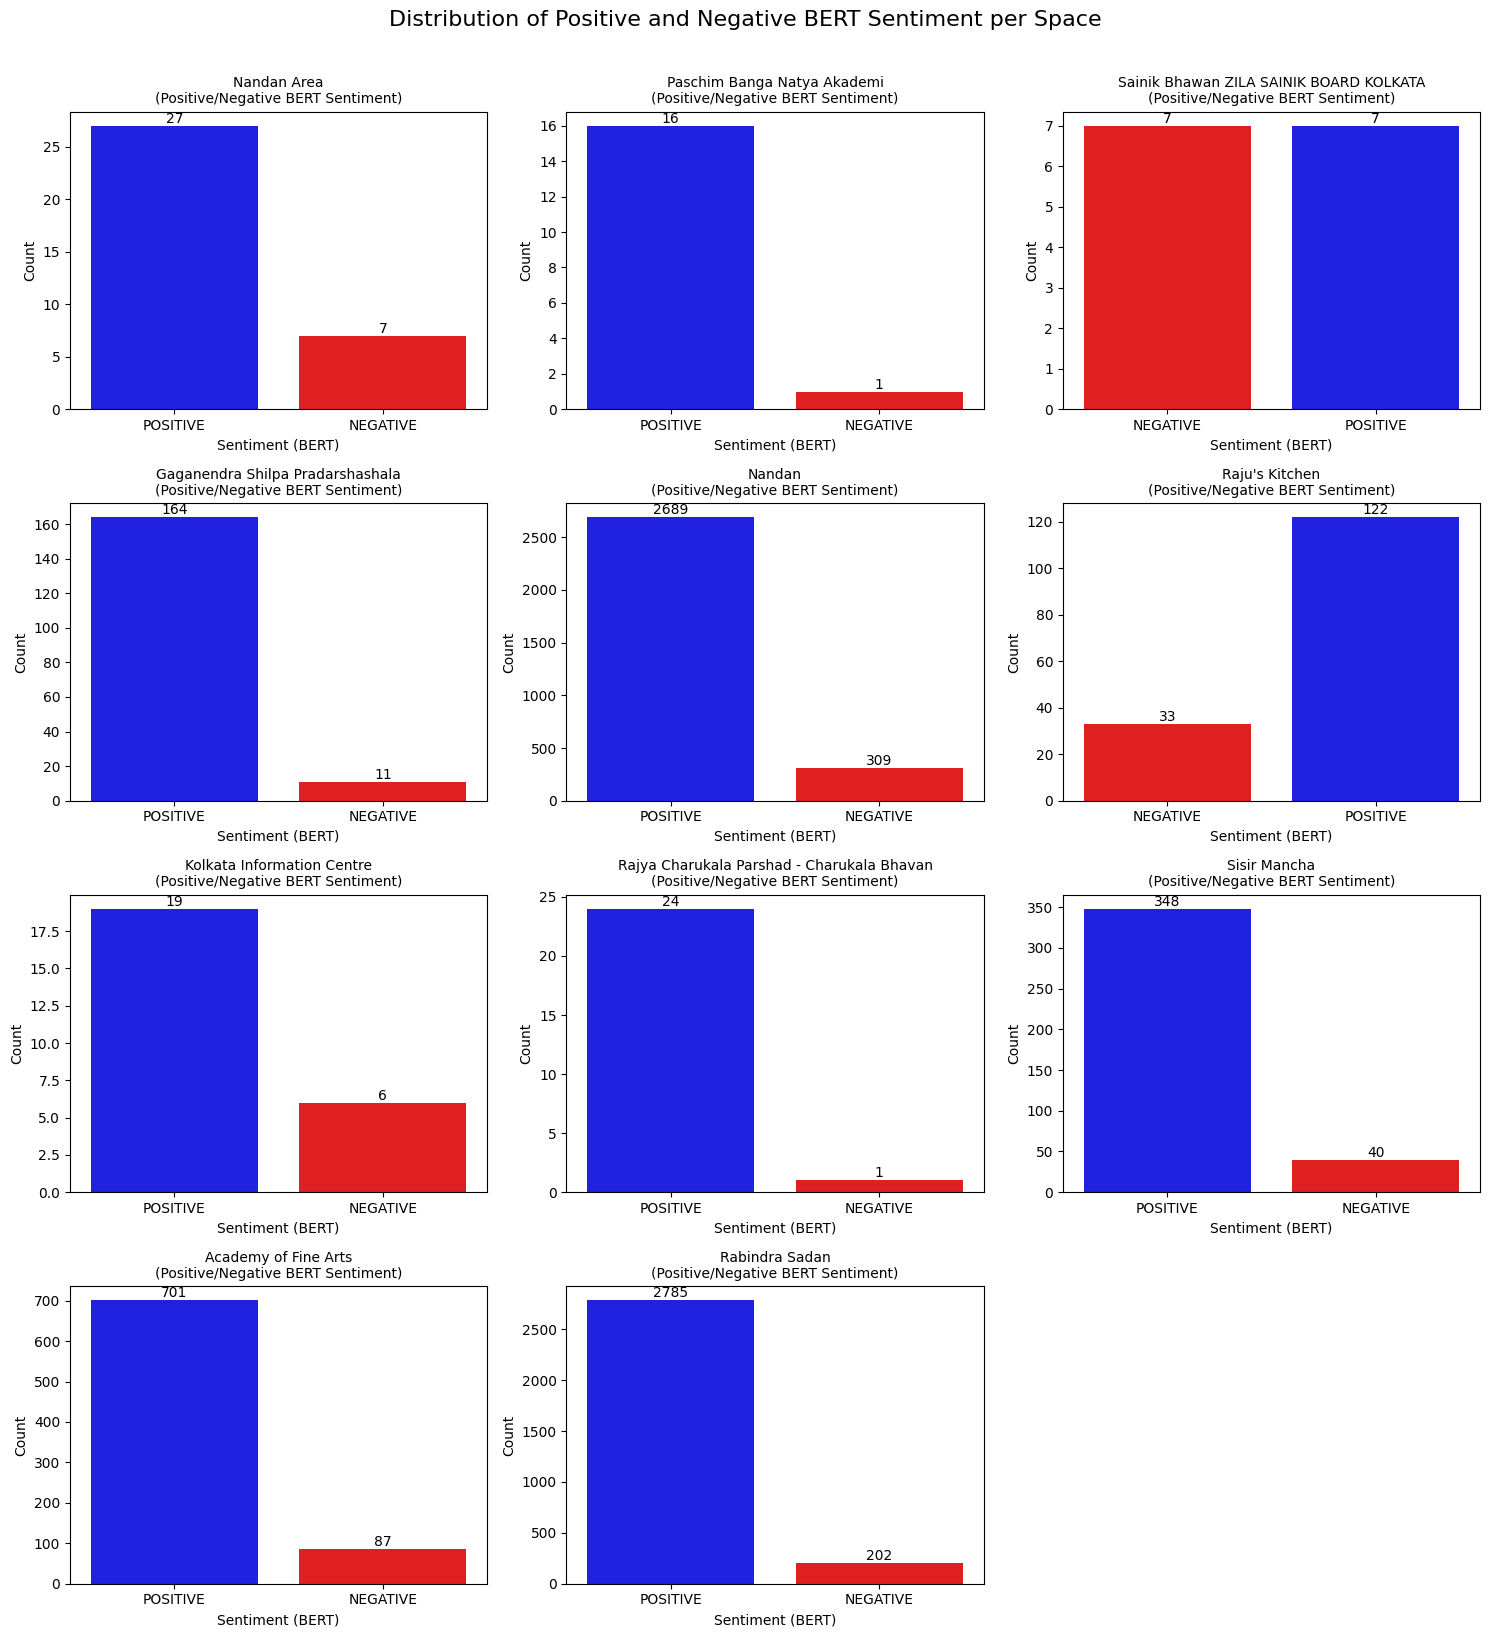

In [19]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Use the final_sentiment_df with BERT results
spaces = final_sentiment_df["location"].unique()
n_spaces = len(spaces)
n_cols = 3
n_rows = math.ceil(n_spaces / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, space in enumerate(spaces):
    # Filter for the current space
    subset = final_sentiment_df[final_sentiment_df["location"] == space]

    # Filter for Positive and Negative sentiment
    sentiment_subset = subset[subset['sentiment (bert)'].isin(['POSITIVE', 'NEGATIVE'])]

    # Countplot of Positive and Negative sentiment
    sns.countplot(
        data=sentiment_subset,
        x='sentiment (bert)', # Use the BERT sentiment label column
        hue='sentiment (bert)',
        ax=axes[i],
        palette={'POSITIVE': 'blue', 'NEGATIVE': 'red'}, # Use distinct colors
        legend=False
    )

    axes[i].set_title(f"{space}\n(Positive/Negative BERT Sentiment)", fontsize=10)
    axes[i].set_xlabel("Sentiment (BERT)")
    axes[i].set_ylabel("Count")
    # Add counts on top of bars
    for container in axes[i].containers:
        axes[i].bar_label(container)


# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Positive and Negative BERT Sentiment per Space", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1.01])
plt.show()

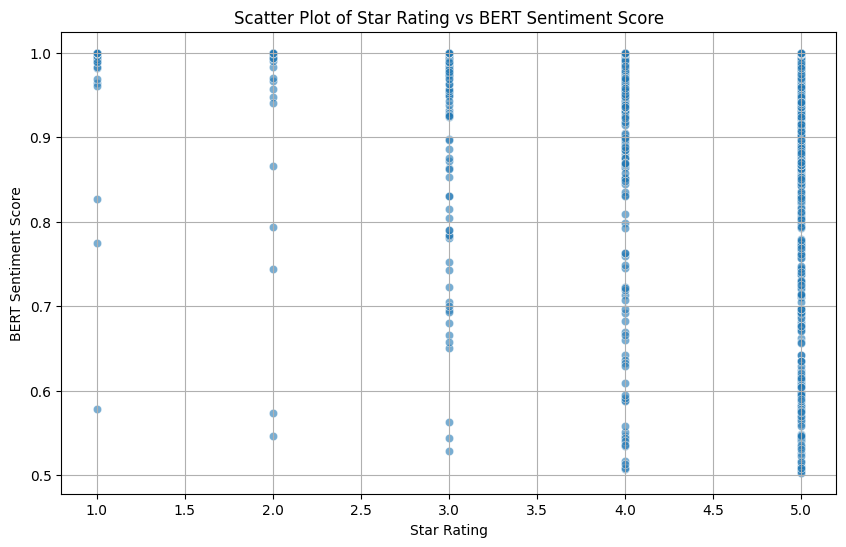

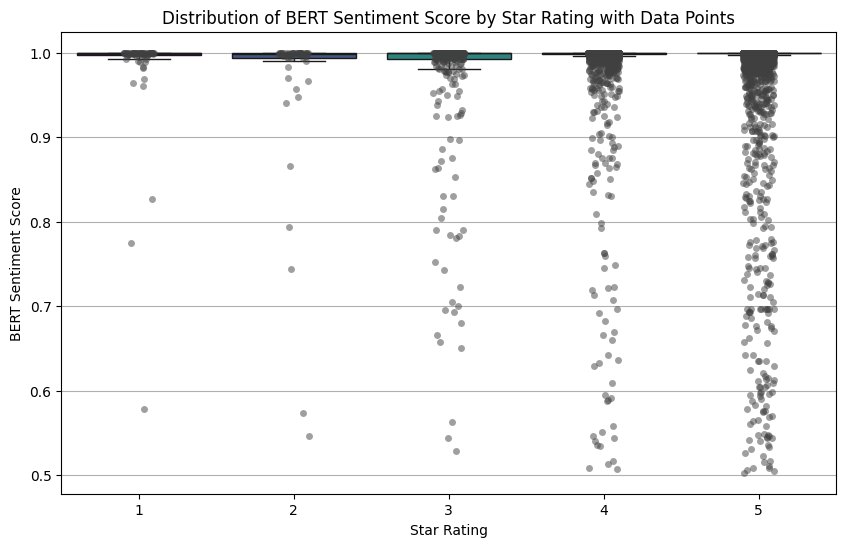

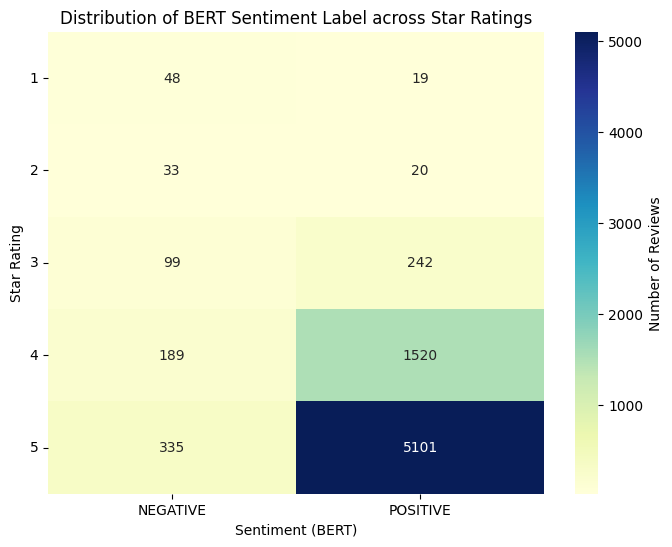

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas if not already imported

# Create a scatter plot of Stars vs Sentiment Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_sentiment_df, x='stars', y='sentiment score', alpha=0.6)
plt.title('Scatter Plot of Star Rating vs BERT Sentiment Score')
plt.xlabel('Star Rating')
plt.ylabel('BERT Sentiment Score')
plt.grid(True)
plt.show()

# Create a box plot of BERT sentiment score vs. Star Rating
plt.figure(figsize=(10, 6))
sns.boxplot(data=final_sentiment_df, x='stars', y='sentiment score', palette='viridis', showfliers=False, hue='stars', legend=False) # Added hue='stars' and legend=False
sns.stripplot(data=final_sentiment_df, x='stars', y='sentiment score', color=".25", alpha=0.5, jitter=True) # Add a stripplot to show individual points
plt.title('Distribution of BERT Sentiment Score by Star Rating with Data Points')
plt.xlabel('Star Rating')
plt.ylabel('BERT Sentiment Score')
plt.grid(axis='y')
plt.show()

# Create a cross-tabulation of Star Rating and BERT Sentiment Label
# We only consider POSITIVE and NEGATIVE for the heatmap as requested in previous plots
sentiment_counts = final_sentiment_df[final_sentiment_df['sentiment (bert)'].isin(['POSITIVE', 'NEGATIVE'])].groupby(['stars', 'sentiment (bert)']).size().unstack(fill_value=0)

# Ensure all star ratings 1-5 are present, even if no reviews have sentiment
all_stars = pd.DataFrame(index=range(1, 6))
sentiment_counts = all_stars.join(sentiment_counts, how='left').fillna(0)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sentiment_counts, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Number of Reviews'})
plt.title('Distribution of BERT Sentiment Label across Star Ratings')
plt.xlabel('Sentiment (BERT)')
plt.ylabel('Star Rating')
plt.yticks(rotation=0) # Keep star ratings horizontal
plt.show()

In [21]:
# Filter for 1-star reviews classified as POSITIVE by BERT
one_star_positive = final_sentiment_df[(final_sentiment_df['stars'] == 1) & (final_sentiment_df['sentiment (bert)'] == 'POSITIVE')]

# Filter for 5-star reviews classified as NEGATIVE by BERT
five_star_negative = final_sentiment_df[(final_sentiment_df['stars'] == 5) & (final_sentiment_df['sentiment (bert)'] == 'NEGATIVE')]

In [22]:
print("Reviews with 1 Star Rating but Positive BERT Sentiment:")
display(one_star_positive[['location', 'stars', 'review', 'sentiment (bert)', 'sentiment score']])

Reviews with 1 Star Rating but Positive BERT Sentiment:


,location,stars,review,sentiment (bert),sentiment score
70,Paschim Banga Natya Akademi,1,Fine,POSITIVE,0.999834
1748,Nandan,1,Been to Nandan several times. Recently went to...,POSITIVE,0.997507
1830,Nandan,1,Disgusting behaviour from the guard. But u can...,POSITIVE,0.964198
2330,Nandan,1,Very nice place for meeting with friend and ph...,POSITIVE,0.999841
3061,Nandan,1,Though it is basically a cinema hall but can c...,POSITIVE,0.996752
3214,Nandan,1,It is a cinema hall situated in the back side ...,POSITIVE,0.998024
3378,Nandan,1,Best place to spend time,POSITIVE,0.995722
3590,Raju's Kitchen,1,Arogant owner,POSITIVE,0.577868
3887,Kolkata Information Centre,1,All Official Information You can Have.,POSITIVE,0.996602
4261,Sisir Mancha,1,Car parking,POSITIVE,0.992904


In [23]:
print("\nReviews with 5 Star Rating but Negative BERT Sentiment:")
display(five_star_negative[['location', 'stars', 'review', 'sentiment (bert)', 'sentiment score']])


Reviews with 5 Star Rating but Negative BERT Sentiment:


,location,stars,review,sentiment (bert),sentiment score
22,Nandan Area,5,✌️✌️✌️,NEGATIVE,0.697056
26,Nandan Area,5,"নন্দন মানে আবেগ, নন্দন মানে ভালোবাসা ❤️❤️",NEGATIVE,0.624055
29,Nandan Area,5,❤️,NEGATIVE,0.697056
30,Nandan Area,5,নন্দনে children flim festival চলছে। ভেতর টা দা...,NEGATIVE,0.906266
32,Nandan Area,5,Aladaiii shanti r oitijho ache jaigatar,NEGATIVE,0.945685
...,...,...,...,...,...
9371,Rabindra Sadan,5,Everything available in highly densed place..,NEGATIVE,0.984637
9375,Rabindra Sadan,5,Rabindra Sadan.near Excide more.,NEGATIVE,0.990628
9381,Rabindra Sadan,5,Gr8 place for watching movie or theater,NEGATIVE,0.740304
9425,Rabindra Sadan,5,U r looking for tip of breaths than u come thi...,NEGATIVE,0.987703


## Extraction of Aspects

In [25]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Download necessary NLTK data (if you haven't already)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Get standard English stop words
stop_words = set(stopwords.words('english'))

# Add custom domain-specific stop words for aspect extraction
# These include general sentiment words and space names identified as less useful for aspects
custom_aspect_stopwords = stop_words.union({
    "good", "nice", "great", "best", "awesome", "excellent", "beautiful",
    "place", "kolkata", "bengal", "west", "nandan", "rabindra", "sadan"
})

# Function for text cleaning for aspect extraction using custom stop words
def clean_text_for_aspects(text):
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs

    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only letters, numbers, and spaces
    # Remove custom stop words for aspects
    words = text.split()
    cleaned_words = [word for word in words if word not in custom_aspect_stopwords]

    # Join words back into a string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply cleaning to the 'review' column and create a new column within this cell
final_sentiment_df['cleaned_review_for_aspects'] = final_sentiment_df['review'].apply(clean_text_for_aspects)

# Now perform the TF-IDF calculation on the cleaned text
# Initialize TF-IDF Vectorizer with ngrams (1, 2)
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,          # Term must appear in at least 5 documents
    max_df=0.95,       # Term will be ignored if it appears in more than 95% of documents
    ngram_range=(1, 2) # Include unigrams (single words) and bigrams (two-word phrases)
)

# Fit and transform the 'cleaned_review_for_aspects' column
tfidf_matrix = tfidf_vectorizer.fit_transform(final_sentiment_df['cleaned_review_for_aspects'].astype(str))

# Get feature names (terms and ngrams)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the sum of TF-IDF scores for each term/ngram
sum_tfidf = tfidf_matrix.sum(axis=0)

# Create a DataFrame for terms/ngrams and their total TF-IDF scores with short column names
tfidf_scores_df = pd.DataFrame({'term': feature_names, 'total_tfidf': sum_tfidf.flat})

# Sort by total TF-IDF score in descending order and display the top terms/ngrams
top_terms_ngrams = tfidf_scores_df.sort_values(by='total_tfidf', ascending=False).head(50)
print("Top 50 TF-IDF Terms and Ngrams:")
display(top_terms_ngrams)

Top 50 TF-IDF Terms and Ngrams:


,term,total_tfidf
942,cultural,273.604711
1711,hall,165.857516
2618,one,161.388327
292,art,144.147883
2401,movie,141.028743
463,bengali,130.370616
3858,visit,127.369388
1557,friends,124.138807
176,also,122.445767
3709,time,121.526617


Lot of Noise in the features ( stop words are to be removed and make features like ngrams rather than single words )


In [26]:
import re
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data (if you haven't already)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Get standard English stop words
stop_words = set(stopwords.words('english'))

# Function for text cleaning for aspect extraction
def clean_text_for_aspects(text):
    if not isinstance(text, str):
        return "" # Return empty string for non-string inputs

    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only letters, numbers, and spaces
    # Remove standard stop words
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]

    # Join words back into a string
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

# Apply cleaning to the 'review' column and create a new column
final_sentiment_df['cleaned_review_for_aspects'] = final_sentiment_df['review'].apply(clean_text_for_aspects)

# Display the original review and the cleaned text
display(final_sentiment_df[['review', 'cleaned_review_for_aspects']].head())

,review,cleaned_review_for_aspects
0,Lovely place to get rid of all your overthinki...,lovely place get rid overthinking depression r...
1,Nandan is a government-sponsored film and cult...,nandan governmentsponsored film cultural centr...
2,Indeed West Bengals heart . The most popular a...,indeed west bengals heart popular area west be...
3,"The cultural hub of Bengal, almost all kinds o...",cultural hub bengal almost kinds art culture e...
4,Very nice.... Calming and peaceful place...,nice calming peaceful place


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize TF-IDF Vectorizer with ngrams (2, 2) - only bigrams
# Apply this to the 'cleaned_review_for_aspects' column
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,          # Term must appear in at least 5 documents
    max_df=0.95,       # Term will be ignored if it appears in more than 95% of documents
    ngram_range=(2, 2) # Include only bigrams (two-word phrases)
)

# Fit and transform the 'cleaned_review_for_aspects' column
# Ensure the column is treated as string
tfidf_matrix = tfidf_vectorizer.fit_transform(final_sentiment_df['cleaned_review_for_aspects'].astype(str))

# Get feature names (only bigrams)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the sum of TF-IDF scores for each bigram
sum_tfidf = tfidf_matrix.sum(axis=0)

# Create a DataFrame for bigrams and their total TF-IDF scores
tfidf_scores_df = pd.DataFrame({'ngram': feature_names, 'total_tfidf': sum_tfidf.flat}) # Renamed 'term' to 'ngram'

# Sort by total TF-IDF score in descending order and display the top bigrams
top_ngrams = tfidf_scores_df.sort_values(by='total_tfidf', ascending=False)
print("Top 50 TF-IDF Bigrams:")
display(top_ngrams.head(50))

# You can further analyze top ngrams per space and sentiment later

Top 50 TF-IDF Bigrams:


,ngram,total_tfidf
934,good place,226.191252
1596,nice place,221.064359
1986,rabindra sadan,136.012784
327,best place,128.649071
980,great place,120.673269
...,...,...
337,bhattacharjee officially,0.709429
5,1985 filmmaker,0.709429
2135,significance rabindra,0.680456
1637,one highlights,0.628732


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Use the final_sentiment_df which contains 'location', 'cleaned_review_for_aspects', and 'sentiment (bert) adjusted'
spaces = final_sentiment_df["location"].unique()
sentiment_labels = ['POSITIVE', 'NEGATIVE'] # Focus on positive and negative sentiment

top_n = 20 # Number of top bigrams to display per category

tfidf_results_per_category = {}

print(f"Calculating TF-IDF for top {top_n} bigrams per Location and Sentiment...\n")

for space in spaces:
    tfidf_results_per_category[space] = {}
    for sentiment in sentiment_labels:
        print(f"Processing: {space} - {sentiment}")

        # Filter data by location and sentiment
        subset_df = final_sentiment_df[
            (final_sentiment_df["location"] == space) &
            (final_sentiment_df["sentiment (bert)"] == sentiment)
        ].copy() # Use adjusted sentiment and create a copy

        # Check if there are enough reviews in this category for meaningful TF-IDF
        # min_df=2 now requires terms to appear in at least 2 documents
        if subset_df.shape[0] < 2: # Need at least min_df=2 reviews
            print(f"  Note: Not enough reviews ({subset_df.shape[0]}) for {space} - {sentiment} to calculate TF-IDF with min_df=2.\n")
            tfidf_results_per_category[space][sentiment] = pd.DataFrame(columns=['ngram', 'total_tfidf']) # Store empty DataFrame
            continue

        # Initialize TF-IDF Vectorizer for bigrams
        # Lowered min_df to 2 to get results for smaller categories
        tfidf_vectorizer = TfidfVectorizer(
            min_df=2, # Lowered min_df
            max_df=0.95,
            ngram_range=(2, 2) # Only bigrams
        )

        # Fit and transform the cleaned text for this subset
        # Ensure the column is treated as string
        try:
            tfidf_matrix = tfidf_vectorizer.fit_transform(subset_df['cleaned_review_for_aspects'].astype(str))

            # Get feature names (bigrams)
            feature_names = tfidf_vectorizer.get_feature_names_out()

            # Check if any terms were found after fitting
            if tfidf_matrix.shape[1] == 0:
                print(f"  Note: No bigrams found for {space} - {sentiment} even with min_df=2.\n")
                tfidf_results_per_category[space][sentiment] = pd.DataFrame(columns=['ngram', 'total_tfidf']) # Store empty DataFrame
                continue


            # Calculate the sum of TF-IDF scores for each bigram in this subset
            sum_tfidf = tfidf_matrix.sum(axis=0)

            # Create a DataFrame for bigrams and their total TF-IDF scores
            tfidf_scores_df = pd.DataFrame({'ngram': feature_names, 'total_tfidf': sum_tfidf.flat})

            # Sort by total TF-IDF score and get top N
            top_ngrams = tfidf_scores_df.sort_values(by='total_tfidf', ascending=False).head(top_n)

            tfidf_results_per_category[space][sentiment] = top_ngrams # Store the results

            # Display results for this category
            print(f"Top {top_n} Bigrams for {space} - {sentiment}:")
            display(top_ngrams)
            print("-" * 50) # Separator

        except ValueError as e:
             # This catch is for other potential ValueErrors during fit_transform
             print(f"  Could not calculate TF-IDF for {space} - {sentiment}: {e}\n")
             tfidf_results_per_category[space][sentiment] = pd.DataFrame(columns=['ngram', 'total_tfidf']) # Store empty DataFrame
             continue


# At this point, tfidf_results_per_category dictionary holds the top bigrams for each space and sentiment.
# You can access the results for a specific category like: tfidf_results_per_category['Nandan']['POSITIVE']

Calculating TF-IDF for top 20 bigrams per Location and Sentiment...

Processing: Nandan Area - POSITIVE
Top 20 Bigrams for Nandan Area - POSITIVE:


,ngram,total_tfidf
0,awesome place,1.707107
4,film festival,1.707107
3,cultural hub,1.707107
5,place kolkata,1.707107
6,west bengal,1.577350
2,cultural centre,1.284457
1,centre kolkata,1.284457


--------------------------------------------------
Processing: Nandan Area - NEGATIVE
  Could not calculate TF-IDF for Nandan Area - NEGATIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Paschim Banga Natya Akademi - POSITIVE
Top 20 Bigrams for Paschim Banga Natya Akademi - POSITIVE:


,ngram,total_tfidf
28,rabindra sadan,1.847798
23,performing art,1.668656
16,intimate theatre,1.414214
24,place intimate,1.414214
33,west bengal,0.883232
19,natya academy,0.817132
18,mitra natya,0.781282
22,paschimbanga natya,0.781282
20,natya griha,0.781282
5,basement paschimbanga,0.781282


--------------------------------------------------
Processing: Paschim Banga Natya Akademi - NEGATIVE
  Note: Not enough reviews (1) for Paschim Banga Natya Akademi - NEGATIVE to calculate TF-IDF with min_df=2.

Processing: Sainik Bhawan ZILA SAINIK BOARD KOLKATA - POSITIVE
  Could not calculate TF-IDF for Sainik Bhawan ZILA SAINIK BOARD KOLKATA - POSITIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Sainik Bhawan ZILA SAINIK BOARD KOLKATA - NEGATIVE
  Could not calculate TF-IDF for Sainik Bhawan ZILA SAINIK BOARD KOLKATA - NEGATIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Gaganendra Shilpa Pradarshashala - POSITIVE
Top 20 Bigrams for Gaganendra Shilpa Pradarshashala - POSITIVE:


,ngram,total_tfidf
103,nice place,11.304295
43,exhibition hall,10.116897
66,good place,8.710366
115,place exhibition,8.366565
7,art gallery,7.963755
4,art exhibition,5.193632
70,great place,4.369420
113,place art,4.321976
166,well maintained,4.071147
57,gaganendra shilpa,3.938211


--------------------------------------------------
Processing: Gaganendra Shilpa Pradarshashala - NEGATIVE
  Could not calculate TF-IDF for Gaganendra Shilpa Pradarshashala - NEGATIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Nandan - POSITIVE
Top 20 Bigrams for Nandan - POSITIVE:


,ngram,total_tfidf
986,cinema hall,57.546310
3701,nice place,48.450941
720,best place,48.355926
2231,good place,47.939616
5645,west bengal,38.257343
1886,film festival,33.188520
2333,great place,32.148732
3771,one best,30.633609
670,bengali movies,30.431834
4486,rabindra sadan,28.038078


--------------------------------------------------
Processing: Nandan - NEGATIVE
Top 20 Bigrams for Nandan - NEGATIVE:


,ngram,total_tfidf
79,cinema hall,11.041037
391,ticket price,8.580633
226,movie theatre,5.965723
419,west bengal,5.658288
270,nice place,5.538842
48,bengali movies,5.468937
113,film festival,5.161027
313,price low,5.069992
392,ticket prices,4.893594
51,best place,4.651775


--------------------------------------------------
Processing: Raju's Kitchen - POSITIVE
Top 20 Bigrams for Raju's Kitchen - POSITIVE:


,ngram,total_tfidf
14,good food,6.393653
11,food good,4.352627
24,nice place,3.331009
32,quality food,3.261146
31,pocket friendly,3.060251
15,good place,2.821026
9,food available,2.670841
33,quality good,2.461499
21,good service,2.000000
42,tasty food,2.000000


--------------------------------------------------
Processing: Raju's Kitchen - NEGATIVE
Top 20 Bigrams for Raju's Kitchen - NEGATIVE:


,ngram,total_tfidf
5,food quality,2.543667
11,worst one,2.000000
7,grab food,1.707107
4,food cheap,1.577350
3,flying around,1.427629
10,stuffing good,1.300582
8,open air,1.186951
9,quality food,1.170826
6,food worth,1.031934
2,crows flying,0.964948


--------------------------------------------------
Processing: Kolkata Information Centre - POSITIVE
Top 20 Bigrams for Kolkata Information Centre - POSITIVE:


,ngram,total_tfidf
2,information center,1.707107
5,police station,1.707107
7,west bengal,1.653572
0,government west,1.653572
3,information centre,1.525405
1,important place,1.525405
4,official information,1.525405
6,sisir mancha,1.525405


--------------------------------------------------
Processing: Kolkata Information Centre - NEGATIVE
  Could not calculate TF-IDF for Kolkata Information Centre - NEGATIVE: After pruning, no terms remain. Try a lower min_df or a higher max_df.

Processing: Rajya Charukala Parshad - Charukala Bhavan - POSITIVE
Top 20 Bigrams for Rajya Charukala Parshad - Charukala Bhavan - POSITIVE:


,ngram,total_tfidf
3,good place,3.027845
0,art lovers,2.735483
1,charukala bhavan,1.577350
4,rajya charukala,1.415104
2,charukala parshad,0.996227


--------------------------------------------------
Processing: Rajya Charukala Parshad - Charukala Bhavan - NEGATIVE
  Note: Not enough reviews (1) for Rajya Charukala Parshad - Charukala Bhavan - NEGATIVE to calculate TF-IDF with min_df=2.

Processing: Sisir Mancha - POSITIVE
Top 20 Bigrams for Sisir Mancha - POSITIVE:


,ngram,total_tfidf
66,good place,17.709436
110,nice place,17.622162
62,good auditorium,8.525159
131,rabindra sadan,5.856196
164,theatre hall,5.504018
107,nice auditorium,5.127886
170,well maintained,4.737561
63,good experience,4.398016
109,nice hall,4.000000
43,cultural programmes,3.811885


--------------------------------------------------
Processing: Sisir Mancha - NEGATIVE
Top 20 Bigrams for Sisir Mancha - NEGATIVE:


,ngram,total_tfidf
18,parking place,2.000000
19,parking space,1.707107
26,sound system,1.707107
25,sisir mancha,1.323928
30,west bengal,0.703870
24,sisir kumar,0.523820
0,acharya jagadish,0.351935
7,bengali theatres,0.351935
8,bose road,0.351935
1,adjacent rabindra,0.351935


--------------------------------------------------
Processing: Academy of Fine Arts - POSITIVE
Top 20 Bigrams for Academy of Fine Arts - POSITIVE:


,ngram,total_tfidf
505,nice place,32.408837
334,good place,25.440077
300,fine arts,21.671192
336,great place,20.166865
555,place art,19.948438
58,art gallery,14.921092
12,academy fine,14.432451
65,art lovers,12.567804
49,art culture,11.485498
52,art exhibition,10.159915


--------------------------------------------------
Processing: Academy of Fine Arts - NEGATIVE
Top 20 Bigrams for Academy of Fine Arts - NEGATIVE:


,ngram,total_tfidf
56,well maintained,2.682696
11,awsome place,2.000000
42,place needs,2.000000
49,seats uncomfortable,2.000000
31,immediate restoration,1.707107
48,sad see,1.707107
45,properly maintained,1.707107
18,difficult find,1.707107
2,academy fine,1.532393
24,fine arts,1.532393


--------------------------------------------------
Processing: Rabindra Sadan - POSITIVE
Top 20 Bigrams for Rabindra Sadan - POSITIVE:


,ngram,total_tfidf
1086,good place,97.963048
1804,nice place,87.236966
2298,rabindra sadan,64.822953
353,best place,50.920283
1123,great place,48.125347
2082,place kolkata,47.486321
2021,place cultural,40.385041
633,cultural place,37.857430
619,cultural hub,32.591674
286,beautiful place,32.256690


--------------------------------------------------
Processing: Rabindra Sadan - NEGATIVE
Top 20 Bigrams for Rabindra Sadan - NEGATIVE:


,ngram,total_tfidf
45,rabindra sadan,7.459437
31,nice place,5.511680
21,good place,5.021882
24,metro station,4.791502
11,crowded place,3.690538
25,movie hall,2.707107
47,sound system,2.686772
6,busy place,2.512939
18,food court,2.427149
2,best place,2.393879


--------------------------------------------------
